# SPTcl-IRAGN SPTpol Targeted IRAC vs SSDF IRAC Comparison
## Author: Benjamin Floyd

Selects a representative SPTpol 100d cluster that has both targeted IRAC and SSDF IRAC imaging. Creates a publication figure that shows the 3.6um images and highlights the objects selected as AGN with the selection membership correction applied.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import imshow_norm, ZScaleInterval, LinearStretch, ImageNormalize
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import json
from astropy.coordinates import SkyCoord
from astropy.table import setdiff

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16})
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [9]:
# For SPT-SZ clusters, read in the look-up table for official -> observed cluster IDs
with open('Data_Repository/Project_Data/SPT-IRAGN/Misc/SPT-SZ_official_to_observed_ids.json', 'r') as f:
    off_to_obs_id = json.load(f)

In [2]:
# Read in the individual survey AGN catalogs
spt_sz_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPT-SZ_2500d_IRAGN.fits')
sptpol_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTpol_100d_IRAGN.fits')

# Get sets of each of the cluster IDs from both surveys and find the common clusters
spt_sz_cluster_ids = set(spt_sz_agn.group_by('SPT_ID').groups.keys['SPT_ID'].data)
sptpol_cluster_ids = set(sptpol_agn.group_by('SPT_ID').groups.keys['SPT_ID'].data)

common_cluster_ids = list(spt_sz_cluster_ids.intersection(sptpol_cluster_ids))

In [3]:
# Pick a random cluster
idx = np.random.randint(len(common_cluster_ids))
example_cluster_id = common_cluster_ids[idx]
print(f'Working with {example_cluster_id}')

In [32]:
# Extract the catalogs for just this cluster
sz_cluster_cat = spt_sz_agn[(spt_sz_agn['SPT_ID'] == example_cluster_id) & (spt_sz_agn['SELECTION_MEMBERSHIP'] >= 0.5)]
pol_cluster_cat = sptpol_agn[(sptpol_agn['SPT_ID'] == example_cluster_id) & (sptpol_agn['SELECTION_MEMBERSHIP'] >= 0.5)]

In [12]:
# Read in the 3.6 um images
sz_cluster_img, sz_cluster_hdr = fits.getdata(f'Data_Repository/Images/SPT/Spitzer_IRAC/SPT-SZ_2500d/I1_{off_to_obs_id[example_cluster_id.decode("utf-8")]}_mosaic.cutout.fits', header=True)
pol_cluster_img, pol_cluster_hdr = fits.getdata(f'Data_Repository/Images/SPT/Spitzer_IRAC/SPTpol_100d/I1_{example_cluster_id.decode("utf-8")}_mosaic.cutout.fits', header=True)

# Get WCSs
sz_cluster_wcs = WCS(sz_cluster_hdr)
pol_cluster_wcs = WCS(pol_cluster_hdr)

Text(349.5, 431.16665333336, '500 kpc')

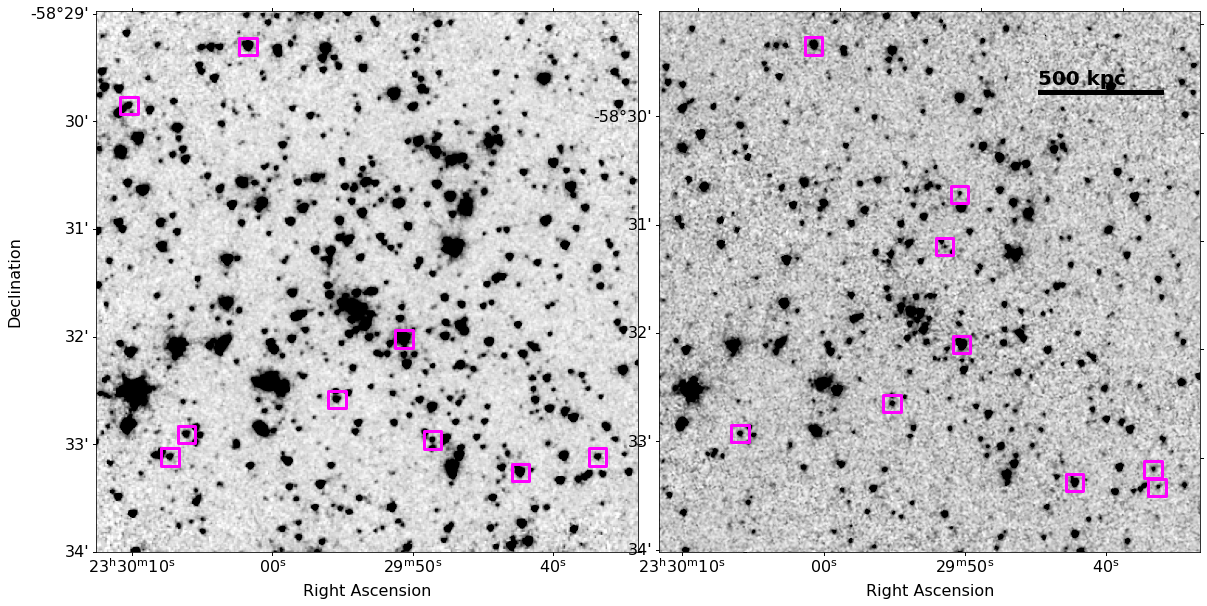

In [14]:
# Make plots
fig = plt.figure(figsize=(16, 8), tight_layout=dict(w_pad=0.5))
sz_cluster_ax = fig.add_subplot(121, projection=sz_cluster_wcs)
pol_cluster_ax = fig.add_subplot(122, projection=pol_cluster_wcs)
sz_cluster_ax.set(xlabel='Right Ascension', ylabel='Declination')
pol_cluster_ax.set(xlabel='Right Ascension', ylabel=' ')
pol_cluster_ax.coords[0].set_auto_axislabel(False)

# Plot the images
imshow_norm(sz_cluster_img, ax=sz_cluster_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch())
imshow_norm(pol_cluster_img, ax=pol_cluster_ax, origin='lower', cmap='Greys', interval=ZScaleInterval(), stretch=LinearStretch())

# Plot the AGN
sz_cluster_ax.scatter(sz_cluster_cat['ALPHA_J2000'], sz_cluster_cat['DELTA_J2000'], marker='s', edgecolor='magenta', facecolor='none', s=300, linewidths=3, transform=sz_cluster_ax.get_transform('world'))
pol_cluster_ax.scatter(pol_cluster_cat['ALPHA_J2000'], pol_cluster_cat['DELTA_J2000'], marker='s', edgecolor='magenta', facecolor='none', s=300, linewidths=3, transform=pol_cluster_ax.get_transform('world'))

# Add scale bar
pol_cluster_scale = (500 * u.kpc * cosmo.arcsec_per_kpc_proper(pol_cluster_cat['REDSHIFT'][0]).to(u.deg / u.kpc) / pol_cluster_wcs.proj_plane_pixel_scales()[0])
pol_cluster_scale_point = pol_cluster_ax.transLimits.inverted().transform((0.7, 0.85))
pol_cluster_width = 2 / pol_cluster_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)
pol_cluster_offset = 4 / pol_cluster_wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)

pol_cluster_ax.arrow(pol_cluster_scale_point[0], pol_cluster_scale_point[1], dx=pol_cluster_scale.value, dy=0, head_width=0, head_length=0, fc='black', ec='black', width=pol_cluster_width)
pol_cluster_ax.text(pol_cluster_scale_point[0], pol_cluster_scale_point[1] + pol_cluster_offset, '500 kpc', color='black', fontsize=20, fontweight='bold')

In [43]:
# Match objects
sz_coords = SkyCoord(sz_cluster_cat['ALPHA_J2000'], sz_cluster_cat['DELTA_J2000'], unit=u.deg)
pol_coords = SkyCoord(pol_cluster_cat['ALPHA_J2000'], pol_cluster_cat['DELTA_J2000'], unit=u.deg)

idx, sep, _ = sz_coords.match_to_catalog_sky(pol_coords)
sep_constraint = sep <= 1 * u.arcsec
sz_matches = sz_cluster_cat[sep_constraint]
pol_matches = pol_cluster_cat[idx[sep_constraint]]

# Identify the non-matches
sz_non_matches = setdiff(sz_cluster_cat, sz_matches)
pol_non_matches = setdiff(pol_cluster_cat, pol_matches)

sz_i1_mag = np.concatenate([sz_matches['I1_MAG_APER4'], sz_non_matches['I1_MAG_APER4'], np.full_like(pol_non_matches['I1_MAG_APER4'], 9.)])
pol_i1_mag = np.concatenate([pol_matches['I1_MAG_APER4'], np.full_like(sz_non_matches['I1_MAG_APER4'], 9.), pol_non_matches['I1_MAG_APER4']])

sz_i2_mag = np.concatenate([sz_matches['I2_MAG_APER4'], sz_non_matches['I2_MAG_APER4'], np.full_like(pol_non_matches['I2_MAG_APER4'], 9.)])
pol_i2_mag = np.concatenate([pol_matches['I2_MAG_APER4'], np.full_like(sz_non_matches['I2_MAG_APER4'], 9.), pol_non_matches['I2_MAG_APER4'], ])

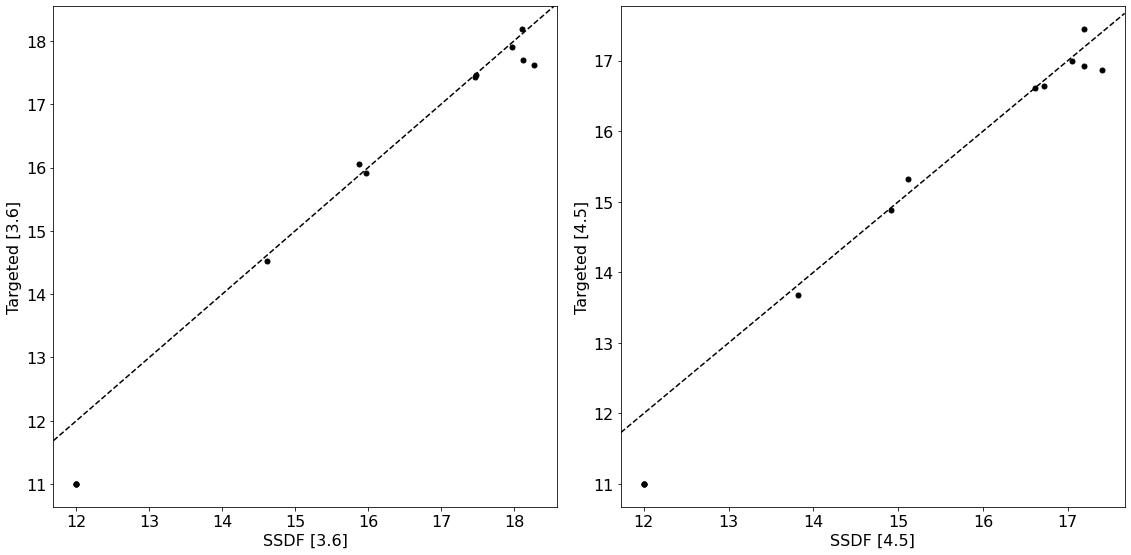

In [42]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)

# Targeted IRAC vs SSDF IRAC 3.6 um
ax1.scatter(pol_i1_mag, sz_i1_mag, marker='.', c='k', s=100)
ax1_xlims, ax1_ylims = ax1.get_xlim(), ax1.get_ylim()
ax1.axline((0., 0.), slope=1, ls='--', c='k')
ax1.set(xlabel='SSDF [3.6]', ylabel='Targeted [3.6]', xlim=ax1_xlims, ylim=ax1_ylims)

# Targeted IRAC vs SSDF IRAC 4.5 um
ax2.scatter(pol_i2_mag, sz_i2_mag, marker='.', c='k', s=100)
ax2_xlims, ax2_ylims = ax2.get_xlim(), ax2.get_ylim()
ax2.axline((0., 0.,), slope=1, ls='--', c='k')
ax2.set(xlabel='SSDF [4.5]', ylabel='Targeted [4.5]', xlim=ax2_xlims, ylim=ax2_ylims)
plt.tight_layout()